In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch
from PIL import Image
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
import math
import einops
import random, os
import numpy as np
from torchvision.utils import make_grid


In [2]:
batch_size = 64
num_workers = 8


In [3]:
class CifarTransformation:    
    def __call__(self, tensor: torch.Tensor):
        return (tensor * 127.5 + 127.5).long().clip(0,255).permute(1,2,0).detach().cpu().numpy()

transform_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5), (.5,.5,.5))
])
transform_to_pil = CifarTransformation()
train_dataset = torchvision.datasets.CIFAR10(root="/home/debugwang/data/CIFAR10/", download=False, transform=transform_to_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = torchvision.datasets.CIFAR10(root="/home/debugwang/data/CIFAR10/", download=False, transform=transform_to_tensor, train=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [4]:

# Create a directory to save the images
save_dir = "/home/debugwang/data/CIFAR10/pid_real/"
os.makedirs(save_dir, exist_ok=True)

# Iterate through the validation dataset and save each image
for idx, (img, label) in enumerate(val_dataset):
    # Convert the tensor to a PIL image
    # pil_img = transform_to_pil(img)
    img = transform_to_pil(img).astype(np.uint8)

    pil_img = Image.fromarray(img)

    # Save the image
    pil_img.save(os.path.join(save_dir, f"image_{idx}.png"))

In [5]:

# Define the dataset and transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# Visualize a batch of images
images, label = next(iter(train_dataset))
print(f"Batch Image Shape: {images.shape}")

# Show the first image in the batch
plt.imshow(images[0].permute(1, 2, 0))  # Convert to HxWxC for visualization
plt.title("First Image in Batch")
plt.show()
print(label[0])
plt.show()

Batch Image Shape: torch.Size([3, 32, 32])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [6]:
class DDPM(nn.Module):
    def __init__(
        self,
        T: int,
        eps_model: nn.Module,
        device: str
    ):
        super().__init__()
        self.T = T
        self.eps_model = eps_model.to(device)
        self.device = device
        beta_schedule = torch.linspace(1e-4, 0.02, T + 1, device=device)
        alpha_t_schedule = 1 - beta_schedule
        bar_alpha_t_schedule = torch.cumprod(alpha_t_schedule.detach().cpu(), 0).to(device)
        sqrt_bar_alpha_t_schedule = torch.sqrt(bar_alpha_t_schedule)
        sqrt_minus_bar_alpha_t_schedule = torch.sqrt(1 - bar_alpha_t_schedule)
        self.register_buffer("beta_schedule", beta_schedule)
        self.register_buffer("alpha_t_schedule", alpha_t_schedule)
        self.register_buffer("bar_alpha_t_schedule", bar_alpha_t_schedule)
        self.register_buffer("sqrt_bar_alpha_t_schedule", sqrt_bar_alpha_t_schedule)
        self.register_buffer("sqrt_minus_bar_alpha_t_schedule", sqrt_minus_bar_alpha_t_schedule)
        self.criterion = nn.MSELoss()

    def forward(self, imgs):
        # random choose some time steps
        t = torch.randint(low=1, high=self.T+1, size=(imgs.shape[0],), device=self.device)

        # get random noise to add it to the images
        noise = torch.randn_like(imgs, device=self.device)

        # get noise image as: sqrt(alpha_t_bar) * x0 + noise * sqrt(1 - alpha_t_bar)
        batch_size, channels, width, height = imgs.shape
        noise_imgs = self.sqrt_bar_alpha_t_schedule[t].view((batch_size, 1, 1 ,1)) * imgs \
            + self.sqrt_minus_bar_alpha_t_schedule[t].view((batch_size, 1, 1, 1)) * noise
        
        # get predicted noise from our model
        pred_noise = self.eps_model(noise_imgs, t.unsqueeze(1))

        # calculate of Loss simple ||noise - pred_noise||^2, which is MSELoss
        return self.criterion(pred_noise, noise)
    
    def sample(self, n_samples, size):
        self.eval()
        with torch.no_grad():
            # get normal noise
            x_t = torch.randn(n_samples, *size, device=self.device)
            # calculate x_(t-1) on every iteration
            for t in range(self.T, 0, -1):
                t_tensor = torch.tensor([t], device=self.device).repeat(x_t.shape[0], 1)
                # get predicted noise from model
                pred_noise = self.eps_model(x_t, t_tensor)

                # get some noise to calculate x_(t-1) as in formula (How to get a Noise)
                # for t = 0, noise should be 0
                z = torch.randn_like(x_t, device=self.device) if t > 0 else 0

                # Formula from How to get sample
                # x_(t-1) = 1 / sqrt(alpha_t) * (x_t - pred_noise * (1 - alpha_t) / sqrt(1 - alpha_t_bar)) + beta_t * eps
                x_t = 1 / torch.sqrt(self.alpha_t_schedule[t]) * \
                    (x_t - pred_noise * (1 - self.alpha_t_schedule[t]) / self.sqrt_minus_bar_alpha_t_schedule[t]) + \
                    torch.sqrt(self.beta_schedule[t]) * z
            return x_t

In [21]:
def train(
    model: DDPM,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: str,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader
):
    training_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train(True)
        training_loss = 0
        val_loss = 0
        pbar = tqdm.tqdm(train_dataloader)
        for index, (imgs, labels) in enumerate(pbar):
            optimizer.zero_grad()
            
            imgs = imgs.to(device)
    
            loss = model(imgs)
    
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            pbar.set_description(f"loss for epoch {epoch}: {training_loss / (index + 1):.4f}")
        model.eval()
        with torch.no_grad():
            for index, (imgs, labels) in enumerate(val_dataloader):
                imgs = imgs.to(device)
                
                loss = model(imgs)
        
                val_loss += loss.item()
                if index == 0 and epoch % 10 == 0:
                    x_t = model.sample(n_samples=16, size=imgs[0].shape)
                    grid = make_grid(x_t, nrow=4)
                    grid = transform_to_pil(grid).astype(np.uint8)
                    grid_img = Image.fromarray(grid)
                    grid_img.save(f"sample_{epoch}.png")

        training_losses.append(training_loss / len(val_dataloader))
        val_losses.append(val_loss / len(val_dataloader))
    return training_losses, val_losses


In [22]:

class MLP(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.ln = nn.Sequential(
            nn.ReLU(),
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.ln(x)
    
class PositionalEmbedding(nn.Module):
    def __init__(self, T: int, output_dim: int) -> None:
        super().__init__()
        self.output_dim = output_dim
        position = torch.arange(T).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, output_dim, 2) * (-math.log(10000.0) / output_dim))
        pe = torch.zeros(T, output_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        return self.pe[x].reshape(x.shape[0], self.output_dim)
    
class MultiheadAttention(nn.Module):
    def __init__(self, n_heads: int, emb_dim: int, input_dim: int) -> None:
        super().__init__()
        assert emb_dim % n_heads == 0
        head_dim = emb_dim // n_heads
        self.K_W = nn.Parameter(torch.rand(n_heads, input_dim, head_dim))
        self.K_b = nn.Parameter(torch.rand(n_heads, head_dim))
        self.Q_W = nn.Parameter(torch.rand(n_heads, input_dim, head_dim))
        self.Q_b = nn.Parameter(torch.rand(n_heads, head_dim))
        self.V_W = nn.Parameter(torch.rand(n_heads, input_dim, head_dim))
        self.V_b = nn.Parameter(torch.rand(n_heads, head_dim))
        self.O_W = nn.Parameter(torch.rand(n_heads, head_dim, input_dim))
        self.O_b = nn.Parameter(torch.rand(input_dim))
        self.norm = nn.LayerNorm([input_dim])
        self.mlp = nn.Sequential(
            nn.LayerNorm([input_dim]),
            nn.Linear(input_dim, input_dim),
            nn.GELU(),
            nn.Linear(input_dim, input_dim)
        )

    def forward(self, x, t):
        _, input_dim, h, w = x.shape
        x = einops.rearrange(x, "b c h w -> b (h w) c")
        res = x
        res = self.norm(x)
        k = einops.einsum(res, self.K_W, "b size ch, n_h ch h_dim -> b size n_h h_dim")
        k = k + self.K_b
        q = einops.einsum(res, self.Q_W, "b size ch, n_h ch h_dim -> b size n_h h_dim")
        q = q + self.Q_b
        qk = einops.einsum(q, k, "batch s1 n_h h_dim, batch s2 n_h h_dim -> batch n_h s1 s2")
        qk = qk / torch.sqrt(torch.tensor(input_dim, dtype=torch.float))
        qk = qk.softmax(-1)
        v = einops.einsum(res, self.V_W, "b size ch, n_h ch h_dim -> b size n_h h_dim")
        v = v + self.V_b
        res = einops.einsum(qk, v, "batch n_h size size, batch size n_h h_dim -> batch size n_h h_dim")
        res = einops.einsum(res, self.O_W, "batch size n_h h_dim, n_h h_dim ch -> batch size ch")
        res = res + self.O_b
        res = res + x
        res = self.mlp(res) + res
        res = einops.rearrange(res, "b (h w) c -> b c h w", h=h, w=w)
        return res

class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, is_residual=False, is_debug=False):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        )
        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        )
        self.time_emb = MLP(input_dim=time_emb_dim, output_dim=out_channels)
        if in_channels != out_channels:
            self.conv_3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        else:
            self.conv_3 = nn.Identity()
        self.is_debug = is_debug
        self.is_residual = is_residual

    def forward(self, x, t):
        h = self.conv_1(x)
        if t is None:
            return self.conv_3(x) + self.conv_2(h)
        t = self.time_emb(t)
        batch_size, emb_dim = t.shape 
        t = t.view(batch_size, emb_dim, 1, 1)
        if self.is_residual:
            return self.conv_3(x) + self.conv_2(h + t)
        else:
            return self.conv_2(h + t)
        

class DownBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=2)
    
    def forward(self, x, t):
        return self.pool(x)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upscale = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
    
    def forward(self, x, t):
        return self.upscale(x)

class SequenceWithTimeEmbedding(nn.Module):
    def __init__(self, blocks):
        super().__init__()
        self.models = nn.ModuleList(blocks)
    
    def forward(self, x, t):
        for model in self.models:
            x = model(x, t)
        return x

In [23]:

class UNet(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            T,
            steps=(1, 2, 4),
            hid_size = 128,
            attn_step_indexes = [1],
            has_residuals=True,
            num_resolution_blocks=2,
            is_debug = False
        ):
        super().__init__()

        time_emb_dim = hid_size * 4
        self.time_embedding = nn.Sequential(
            PositionalEmbedding(T=T, output_dim=hid_size),
            nn.Linear(hid_size, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.first_conv = nn.Conv2d(in_channels, steps[0] * hid_size, 3, padding=1)
        self.down_blocks = nn.ModuleList()
        prev_hid_size = steps[0] * hid_size
        for (index, step) in enumerate(steps):
            res_blocks = []
            for block in range(num_resolution_blocks):
                res_blocks.append(
                    ResnetBlock(
                        in_channels=prev_hid_size if block == 0 else step * hid_size,
                        out_channels=step * hid_size,
                        time_emb_dim=time_emb_dim,
                        is_residual=has_residuals
                    )
                )
                if step in attn_step_indexes:
                    res_blocks.append(
                        MultiheadAttention(
                            n_heads=4,
                            emb_dim=step * hid_size,
                            input_dim=step * hid_size
                        )
                    )
            self.down_blocks.append(
                SequenceWithTimeEmbedding(res_blocks)
            )
            if index != len(steps) - 1:
                self.down_blocks.append(DownBlock())
            prev_hid_size = step * hid_size
        if len(attn_step_indexes) > 0:
            self.backbone = SequenceWithTimeEmbedding([
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
                MultiheadAttention(n_heads=4, emb_dim=steps[-1] * hid_size, input_dim=steps[-1] * hid_size),
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
            ])
        else:
            self.backbone = SequenceWithTimeEmbedding([
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
                ResnetBlock(steps[-1] * hid_size, steps[-1] * hid_size, time_emb_dim=time_emb_dim),
            ])

        self.up_blocks = nn.ModuleList()
        reverse_steps = list(reversed(steps))
        for (index, step) in enumerate(reverse_steps):
            res_blocks = []
            for block in range(num_resolution_blocks):
                next_hid_size = reverse_steps[index + 1] * hid_size if index != len(steps) - 1 else step * hid_size
                res_blocks.append(
                    ResnetBlock(
                        in_channels=prev_hid_size * 2 if block == 0 else next_hid_size,
                        out_channels=next_hid_size,
                        time_emb_dim=time_emb_dim,
                        is_residual=has_residuals
                    )
                )
                if len(reverse_steps) - index - 1 in attn_step_indexes:
                    res_blocks.append(
                        MultiheadAttention(
                            n_heads=4,
                            emb_dim=next_hid_size,
                            input_dim=next_hid_size
                        )
                    )
            self.up_blocks.append(
                SequenceWithTimeEmbedding(res_blocks)
            )
            if index != len(steps) - 1:
                self.up_blocks.append(UpBlock(next_hid_size, next_hid_size))
            prev_hid_size = next_hid_size

        self.is_debug = is_debug
        self.out = nn.Sequential(*[
            nn.GroupNorm(8, steps[0] * hid_size),
            nn.ReLU(),
            nn.Conv2d(in_channels=steps[0] * hid_size, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        ])

    def forward(self, x, t):
        time_emb = self.time_embedding(t)

        x = self.first_conv(x)
        hx = []
        for down_block in self.down_blocks:
            x = down_block(x, time_emb)
            if not isinstance(down_block, DownBlock):
                hx.append(x)
        x = self.backbone(x, time_emb)

        ind = len(hx) - 1
        for up_block in self.up_blocks:
            if not isinstance(up_block, UpBlock):
                x = up_block(torch.cat([x, hx[ind]], 1), time_emb)
                ind -= 1
            else:
                x = up_block(x, time_emb)
        x = self.out(x)

        return x

In [24]:
T = 1000
EPOCHS = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

ddpm = DDPM(
    T = T,
    eps_model=UNet(
        in_channels=3,
        out_channels=3,
        T=T+1,
        steps=(1,2,2,2),
        attn_step_indexes=[1,2]
    ),
    device=device
)

In [25]:


def seed_everything(seed):   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    if seed is None:
        torch.manual_seed(torch.initial_seed())
        torch.cuda.manual_seed(torch.initial_seed())
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = False
    else:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True


loss for epoch 99: 0.0301: 100%|██████████| 782/782 [02:06<00:00,  6.19it/s]


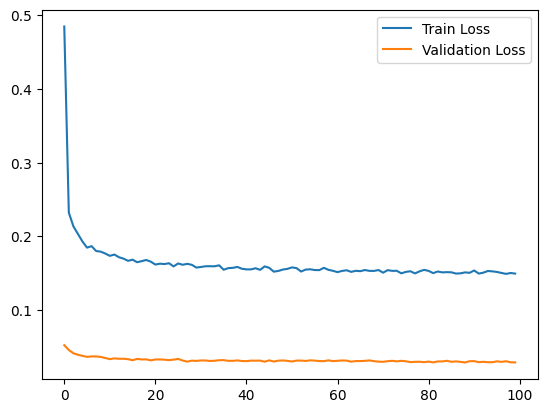

In [26]:
seed_everything(42)
train_losses, val_losses = train(
    model=ddpm,
    optimizer=torch.optim.Adam(params=ddpm.parameters(), lr=2e-4),
    epochs=EPOCHS,
    device=device,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader
)

# path = PATH_TO_SAVE_MODEL if PATH_TO_SAVE_MODEL is not None else "model.pth"
# 
torch.save(ddpm.state_dict(), f"/home/debugwang/reproduce/diffusion_CIFR10/model/diffusion_lr_{2e-4}.pth")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")

plt.legend()
plt.show()


In [27]:
save_dir = "/home/debugwang/data/CIFAR10/pid_fake/"
os.makedirs(save_dir, exist_ok=True)

n_samples = 16
x_t = ddpm.sample(n_samples=n_samples, size=train_dataset[0][0].shape)

result = []
for i in range(x_t.shape[0]):
    img = transform_to_pil(x_t[i]).astype(np.uint8)
    result.append(img)

    pil_img = Image.fromarray(img)

    # Save the image
    pil_img.save(os.path.join(save_dir, f"image_{i}.png"))


In [50]:
grid = make_grid(x_t, nrow=4)
grid = transform_to_pil(grid).astype(np.uint8)
grid_img = Image.fromarray(grid)
grid_img.save(f"sample.png")
# save_image(grid, f"sample.png")

cols = 4
rows = (n_samples // cols) + (0 if n_samples % cols == 0 else 1)
fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
for i in range(len(result)):
    row = i // cols
    axs[row, i % cols].imshow(result[i], cmap='gray')
plt.show()

TypeError: Cannot handle this data type: (1, 1, 3), <i8

In [51]:
grid.shape

dtype('int64')

In [29]:
from pytorch_fid import fid_score

In [30]:
fid_value = fid_score.calculate_fid_given_paths(["/home/debugwang/data/CIFAR10/pid_fake/", "/home/debugwang/data/CIFAR10/pid_real/"], 16, "cuda", 2048)

100%|██████████| 625/625 [00:08<00:00, 70.90it/s]


In [31]:
fid_value

299.62516209568344

316.1005572222162